## IMPORT QAA FUNCTION AND VALUES TO VALIDATE STRATEGIES.....

In [2]:
from functions import QAA
from backtest import BacktestingDinamico
from backtest import backtesting_dinamico, plot_portfolio_value
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import minimize
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from matplotlib.lines import Line2D
import optuna
import warnings
import logging
from pypfopt import EfficientFrontier, risk_models, expected_returns
from pypfopt.efficient_frontier import EfficientCVaR
import yfinance as yf
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, leaves_list
from scipy.spatial.distance import squareform
from pypfopt.hierarchical_portfolio import HRPOpt
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore', message='A new study created in memory with name:')
warnings.filterwarnings('ignore', message='Method COBYLA cannot handle bounds.')


tickers = ["ABBV", "MET", "OXY", "PERI"]
optimization_models = ['SLSQP', 'Monte Carlo', 'COBYLA']

QAA_instance = QAA(tickers=tickers, start_date='2020-01-02', end_date='2024-01-23', rf=0.02)


[*********************100%%**********************]  5 of 5 completed
C:\Users\J3SVS\Downloads\Pruebacommit\functions.py:275: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_data = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start=self.start_date, end=self.end_date)[0]


## Minimum Variance

In [3]:
from pypfopt import expected_returns, risk_models, EfficientFrontier

# Obtén los datos históricos de precios
historical_data = QAA_instance.data

# Calcula el rendimiento esperado y la matriz de covarianza
mu = expected_returns.mean_historical_return(historical_data)
S = risk_models.sample_cov(historical_data)

# Optimiza para la mínima varianza usando PyPortfolioOpt
ef = EfficientFrontier(mu, S, weight_bounds=(0.10,1))
weights_pypfopt = ef.min_volatility()
ef.portfolio_performance(verbose=True)

# Compara los pesos óptimos
print("\nOptimal weights (Library: PyPortfolioOpt):")
print(weights_pypfopt)

# Define a list of strategies to optimize
strategies = ['Minimum Variance']

for strategy in strategies:
    QAA_instance.set_optimization_strategy(strategy)
    for model in optimization_models:
        QAA_instance.set_optimization_model(model)
        QAA_instance.optimize()
        if QAA_instance.optimal_weights is not None:
            print(f"\nOptimal weights in our class ({strategy} - {model}):", [format(weight, '.4f') for weight in QAA_instance.optimal_weights])
        else:
            print(f"\nOptimization for {strategy} with {model} did not converge or is not implemented.")


Expected annual return: 21.9%
Annual volatility: 25.3%
Sharpe Ratio: 0.79

Optimal weights (Library: PyPortfolioOpt):
OrderedDict({'ABBV': 0.7, 'MET': 0.1, 'OXY': 0.1, 'PERI': 0.1})

Optimal weights in our class (Minimum Variance - SLSQP): ['0.7000', '0.1000', '0.1000', '0.1000']

Optimal weights in our class (Minimum Variance - Monte Carlo): ['0.6448', '0.1393', '0.1040', '0.1119']

Optimal weights in our class (Minimum Variance - COBYLA): ['0.6970', '0.1010', '0.1010', '0.1010']


In [4]:
tickers = ["ABBV", "MET", "OXY", "PERI"]
rf = 0.02  # Tasa libre de riesgo
optimization_strategy = 'Minimum Variance'
optimization_model = 'SLSQP'
valor_portafolio_inicial = 1_000_000
frecuencias_rebalanceo_meses = 6

In [5]:
backtesting = BacktestingDinamico(
    tickers=tickers, 
    start_date='2020-01-02', 
    start_backtesting='2023-01-23', 
    end_date='2024-01-23', 
    frecuencias_rebalanceo_meses = [frecuencias_rebalanceo_meses], # Ajustes cada 6 meses
    rf=0.02, 
    optimization_strategy=optimization_strategy, 
    optimization_model=optimization_model,
    valor_portafolio_inicial = valor_portafolio_inicial
)
resultados_backtesting = backtesting.run_backtesting()

resultados_backtesting

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed


,fecha_data_origen,fecha_fin,peso_ABBV,peso_MET,peso_OXY,peso_PERI,acciones_ABBV,acciones_MET,acciones_OXY,acciones_PERI,valor_ABBV,valor_MET,valor_OXY,valor_PERI,cash_sobrante,valor_total_cartera,diff_ABBV,diff_MET,diff_OXY,diff_PERI
0,2020-01-02,2023-01-23,0.7,0.1,0.1,0.1,4914.0,1485.0,1517.0,3367.0,699971.466797,99986.944771,99946.147812,99999.902569,95.538052,1.000000e+06,NaN,NaN,NaN,NaN
1,2020-01-02,2023-07-23,0.7,0.1,0.1,0.1,4913.0,1642.0,1629.0,2891.0,686170.813492,98025.760155,98005.157433,98033.809559,169.850452,9.804054e+05,-1.0,157.0,112.0,-476.0
2,2020-01-02,2024-01-23,0.7,0.1,0.1,0.1,4684.0,1590.0,1939.0,3678.0,767518.884888,109633.697662,109622.659126,109641.178036,122.851847,1.096539e+06,-229.0,-52.0,310.0,787.0


In [6]:
# Realizar el backtesting
resultados_backtesting = backtesting_dinamico(
    tickers=tickers, 
    start_date='2020-01-02', 
    start_backtesting='2023-01-23', 
    end_date='2024-01-23', 
    frecuencias_rebalanceo_meses = [frecuencias_rebalanceo_meses] , # Ajustes cada 2, 3, 4 y 6 meses
    rf=rf, 
    optimization_strategy=optimization_strategy, 
    optimization_model=optimization_model,
    valor_portafolio_inicial = valor_portafolio_inicial
)

resultados_backtesting

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed


,fecha_data_origen,fecha_fin,peso_ABBV,peso_MET,peso_OXY,peso_PERI,acciones_ABBV,acciones_MET,acciones_OXY,acciones_PERI,valor_ABBV,valor_MET,valor_OXY,valor_PERI,cash_sobrante,valor_total_cartera,diff_ABBV,diff_MET,diff_OXY,diff_PERI
0,2020-01-02,2023-01-23,0.7,0.1,0.1,0.1,4914.0,1485.0,1517.0,3367.0,699971.466797,99986.944771,99946.147812,99999.902569,95.538052,1.000000e+06,NaN,NaN,NaN,NaN
1,2020-01-02,2023-07-23,0.7,0.1,0.1,0.1,4913.0,1642.0,1629.0,2891.0,686170.813492,98025.760155,98005.157433,98033.809559,169.850452,9.804054e+05,-1.0,157.0,112.0,-476.0
2,2020-01-02,2024-01-23,0.7,0.1,0.1,0.1,4684.0,1590.0,1939.0,3678.0,767518.884888,109633.697662,109622.659126,109641.178036,122.851847,1.096539e+06,-229.0,-52.0,310.0,787.0


[*********************100%%**********************]  4 of 4 completed


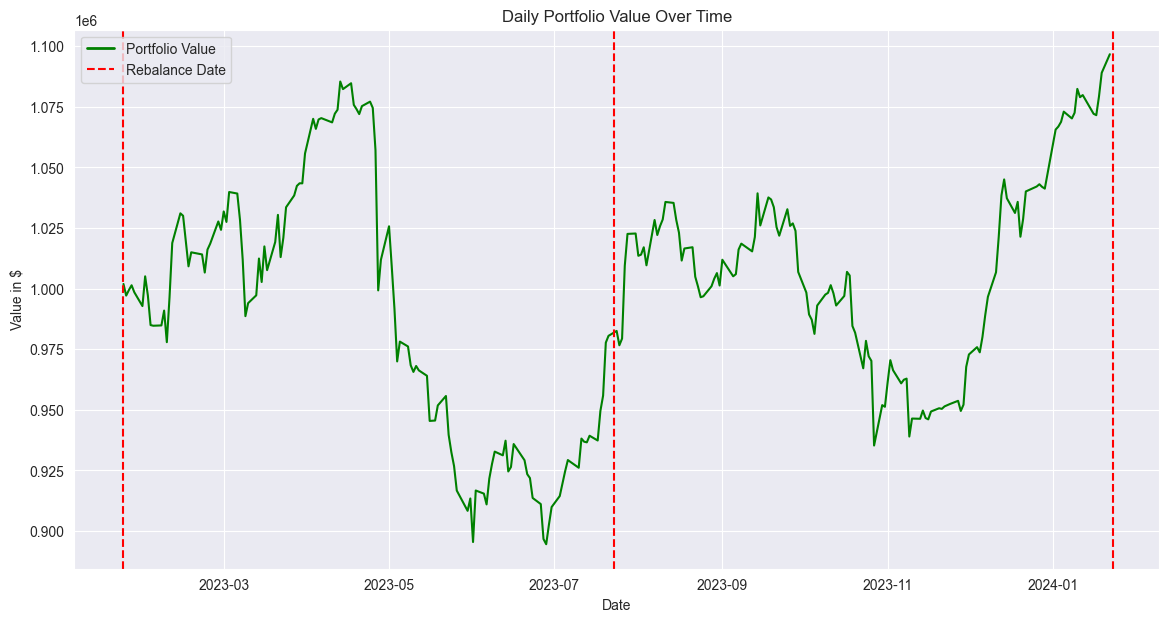

In [7]:
plot_portfolio_value(resultados_backtesting, tickers)

## Omega

In [8]:
# Risk-free rate
rf = 0.02

# Function to calculate the Omega Ratio
def omega_ratio(weights, returns, rf):
    portfolio_returns = np.dot(returns, weights)
    excess_returns = portfolio_returns - rf
    upside_potential = np.sum(excess_returns[excess_returns > 0])
    downside_risk = np.sqrt(np.sum(np.square(excess_returns[excess_returns < 0])))
    return upside_potential / downside_risk if downside_risk != 0 else np.inf

# Objective function for optimization (negative of the Omega Ratio)
def neg_omega_ratio(weights, returns, rf):
    return omega_ratio(weights, returns, rf)

# Load data and calculate returns
tickers = ["ABBV", "MET", "OXY", "PERI"]
data = yf.download(tickers, start='2020-01-02', end='2024-01-23')['Adj Close']
returns = data.pct_change().dropna().values
rf = 0.02 / 252  # Daily risk-free rate

# Constraints and bounds for optimization
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bounds = [(0.10, 1) for _ in tickers]

# Optimization to maximize the Omega Ratio
initial_weights = np.ones(len(tickers)) / len(tickers)
result = minimize(neg_omega_ratio, initial_weights, args=(returns, rf), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = result.x
print("Optimal weights to maximize the Omega Ratio validation:")
print(optimal_weights)

# Instantiation of the optimized strategy
QAA_instance = QAA(tickers=tickers, start_date='2020-01-02', end_date='2024-01-23', rf=0.02)

# Define a list of strategies to optimize
strategies = ["Omega Ratio"]

for strategy in strategies:
    QAA_instance.set_optimization_strategy(strategy)
    for model in optimization_models:
        QAA_instance.set_optimization_model(model)
        QAA_instance.optimize()
        if QAA_instance.optimal_weights is not None:
            print(f"\nOptimal weights in our class ({strategy} - {model}):", [format(weight, '.4f') for weight in QAA_instance.optimal_weights])
        else:
            print(f"\nOptimization for {strategy} with {model} did not converge or is not implemented.")


[*********************100%%**********************]  4 of 4 completed


Optimal weights to maximize the Omega Ratio validation:
[0.1 0.1 0.7 0.1]


[*********************100%%**********************]  5 of 5 completed



Optimal weights in our class (Omega Ratio - SLSQP): ['0.1000', '0.1000', '0.7000', '0.1000']

Optimal weights in our class (Omega Ratio - Monte Carlo): ['0.1096', '0.1072', '0.6751', '0.1081']

Optimal weights in our class (Omega Ratio - COBYLA): ['0.1000', '0.1000', '0.7000', '0.1000']


In [9]:
tickers = ["ABBV", "MET", "OXY", "PERI"]
rf = 0.02  # Tasa libre de riesgo
optimization_strategy = 'Omega Ratio'
optimization_model = 'SLSQP'
valor_portafolio_inicial = 1_000_000
frecuencias_rebalanceo_meses = 6

In [10]:
backtesting = BacktestingDinamico(
    tickers=tickers, 
    start_date='2020-01-02', 
    start_backtesting='2023-01-23', 
    end_date='2024-01-23', 
    frecuencias_rebalanceo_meses = [frecuencias_rebalanceo_meses], # Ajustes cada 6 meses
    rf=0.02, 
    optimization_strategy=optimization_strategy, 
    optimization_model=optimization_model,
    valor_portafolio_inicial = valor_portafolio_inicial
)
resultados_backtesting = backtesting.run_backtesting()

resultados_backtesting

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed


,fecha_data_origen,fecha_fin,peso_ABBV,peso_MET,peso_OXY,peso_PERI,acciones_ABBV,acciones_MET,acciones_OXY,acciones_PERI,valor_ABBV,valor_MET,valor_OXY,valor_PERI,cash_sobrante,valor_total_cartera,diff_ABBV,diff_MET,diff_OXY,diff_PERI
0,2020-01-02,2023-01-23,0.1,0.1,0.7,0.1,702.0,1485.0,10624.0,3367.0,99995.923828,99986.944771,699952.455078,99999.902569,64.773754,1000000.000000,NaN,NaN,NaN,NaN
1,2020-01-02,2023-07-23,0.1,0.1,0.7,0.1,673.0,1574.0,10937.0,2772.0,93994.088638,93966.228065,658000.249748,93998.519577,82.556137,940041.642166,-29.0,89.0,313.0,-595.0
2,2020-01-02,2024-01-23,0.1,0.1,0.7,0.1,561.0,1333.0,11388.0,3085.0,91925.297699,91913.030807,643828.180573,91963.848352,141.606436,919771.963867,-112.0,-241.0,451.0,313.0


In [11]:
# Realizar el backtesting
resultados_backtesting = backtesting_dinamico(
    tickers=tickers, 
    start_date='2020-01-02', 
    start_backtesting='2023-01-23', 
    end_date='2024-01-23', 
    frecuencias_rebalanceo_meses = [frecuencias_rebalanceo_meses] , # Ajustes cada 2, 3, 4 y 6 meses
    rf=rf, 
    optimization_strategy=optimization_strategy, 
    optimization_model=optimization_model,
    valor_portafolio_inicial = valor_portafolio_inicial
)

resultados_backtesting

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed


,fecha_data_origen,fecha_fin,peso_ABBV,peso_MET,peso_OXY,peso_PERI,acciones_ABBV,acciones_MET,acciones_OXY,acciones_PERI,valor_ABBV,valor_MET,valor_OXY,valor_PERI,cash_sobrante,valor_total_cartera,diff_ABBV,diff_MET,diff_OXY,diff_PERI
0,2020-01-02,2023-01-23,0.1,0.1,0.7,0.1,702.0,1485.0,10624.0,3367.0,99995.923828,99986.944771,699952.455078,99999.902569,64.773754,1000000.000000,NaN,NaN,NaN,NaN
1,2020-01-02,2023-07-23,0.1,0.1,0.7,0.1,673.0,1574.0,10937.0,2772.0,93994.088638,93966.228065,658000.249748,93998.519577,82.556137,940041.642166,-29.0,89.0,313.0,-595.0
2,2020-01-02,2024-01-23,0.1,0.1,0.7,0.1,561.0,1333.0,11388.0,3085.0,91925.297699,91913.030807,643828.180573,91963.848352,141.606436,919771.963867,-112.0,-241.0,451.0,313.0


[*********************100%%**********************]  4 of 4 completed


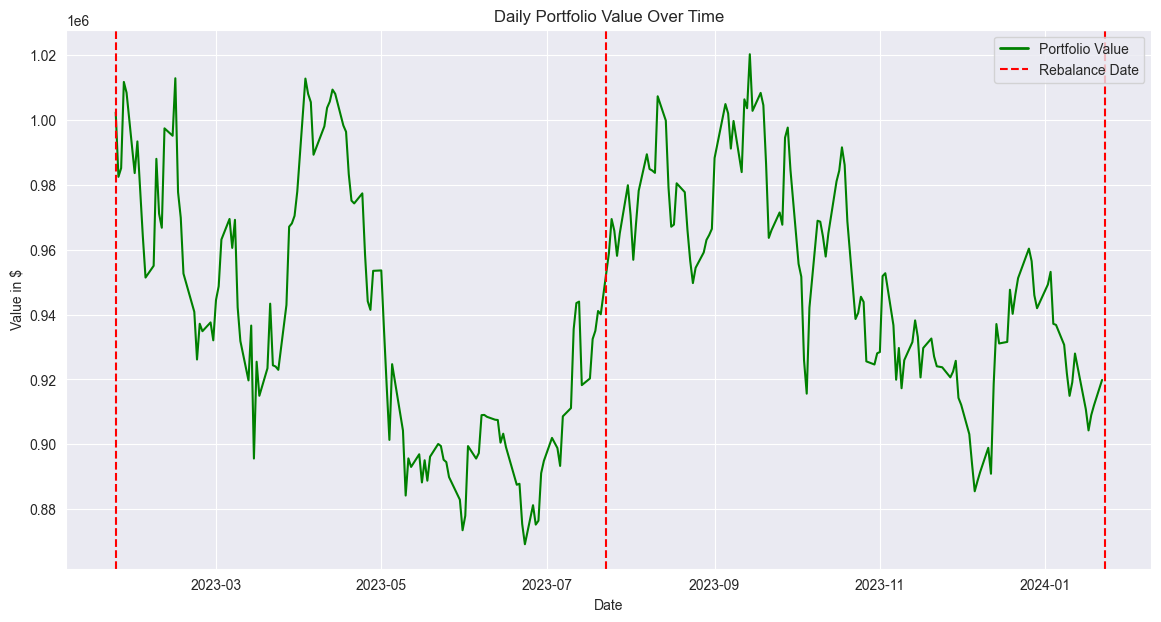

In [12]:
plot_portfolio_value(resultados_backtesting, tickers)

## SEMI VARIANZA

In [13]:
tickers = ["ABBV", "MET", "OXY", "PERI"]
optimization_models = ['SLSQP', 'Monte Carlo', 'COBYLA']

QAA_instance = QAA(tickers=tickers, start_date='2020-01-02', end_date='2024-01-23', rf=0.02)

strategies = ["Semivariance"]

for strategy in strategies:
    QAA_instance.set_optimization_strategy(strategy)
    for model in optimization_models:
        QAA_instance.set_optimization_model(model)
        QAA_instance.optimize()
        if QAA_instance.optimal_weights is not None:
            print(f"\nOptimal weights in our class ({strategy} - {model}):", [format(weight, '.4f') for weight in QAA_instance.optimal_weights])
        else:
            print(f"\nOptimization for {strategy} with {model} did not converge or is not implemented.")

[*********************100%%**********************]  5 of 5 completed



Optimal weights in our class (Semivariance - SLSQP): ['0.5486', '0.2514', '0.1000', '0.1000']

Optimal weights in our class (Semivariance - Monte Carlo): ['0.4725', '0.3185', '0.1033', '0.1058']

Optimal weights in our class (Semivariance - COBYLA): ['0.5484', '0.2495', '0.1010', '0.1010']


In [14]:
tickers = ["ABBV", "MET", "OXY", "PERI"]
rf = 0.02  # Tasa libre de riesgo
optimization_strategy = 'Semivariance'
optimization_model = 'SLSQP'
valor_portafolio_inicial = 1_000_000
frecuencias_rebalanceo_meses = 6
sin_frecuencias_rebalanceo_meses = 48

In [15]:
# Realizar el backtesting
resultados_backtesting = backtesting_dinamico(
    tickers=tickers, 
    start_date='2010-01-02', 
    start_backtesting='2020-01-23', 
    end_date='2024-01-23', 
    frecuencias_rebalanceo_meses = [frecuencias_rebalanceo_meses] , # Ajustes cada 2, 3, 4 y 6 meses
    rf=rf, 
    optimization_strategy=optimization_strategy, 
    optimization_model=optimization_model,
    valor_portafolio_inicial = valor_portafolio_inicial
)

resultados_sin_backtesting = backtesting_dinamico(
    tickers=tickers, 
    start_date='2010-01-02', 
    start_backtesting='2020-01-23', 
    end_date='2024-01-23', 
    frecuencias_rebalanceo_meses = [sin_frecuencias_rebalanceo_meses] , # Ajustes cada 2, 3, 4 y 6 meses
    rf=rf, 
    optimization_strategy=optimization_strategy, 
    optimization_model=optimization_model,
    valor_portafolio_inicial = valor_portafolio_inicial
)

resultados_backtesting

[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%**********************]  5 of 5 completed
[*********************100%%*******

,fecha_data_origen,fecha_fin,peso_ABBV,peso_MET,peso_OXY,peso_PERI,acciones_ABBV,acciones_MET,acciones_OXY,acciones_PERI,valor_ABBV,valor_MET,valor_OXY,valor_PERI,cash_sobrante,valor_total_cartera,diff_ABBV,diff_MET,diff_OXY,diff_PERI
0,2010-01-02,2020-01-23,0.186800,0.394126,0.319074,0.1,2574.0,8823.0,7803.0,10787.0,186762.815689,394094.213161,319040.524944,99995.494938,106.951267,1.000000e+06,NaN,NaN,NaN,NaN
1,2010-01-02,2020-07-23,0.326263,0.473737,0.100000,0.1,2777.0,9953.0,4307.0,11176.0,231890.962074,336737.117149,71081.371284,71079.361492,40.524973,7.108293e+05,203.0,1130.0,-3496.0,389.0
2,2010-01-02,2021-01-23,0.409851,0.390149,0.100000,0.1,4100.0,8264.0,4639.0,6994.0,398379.006195,379286.245575,97212.987585,97216.597332,141.130188,9.722360e+05,1323.0,-1689.0,332.0,-4182.0
3,2010-01-02,2021-07-23,0.412980,0.387020,0.100000,0.1,4392.0,8182.0,4254.0,6104.0,463072.653809,433953.780083,112119.271671,112130.485123,58.360170,1.121335e+06,292.0,-82.0,-385.0,-890.0
4,2010-01-02,2022-01-23,0.413568,0.386432,0.100000,0.1,4393.0,8129.0,3902.0,6891.0,531847.806122,496941.779675,128598.172203,128586.058949,34.367622,1.286008e+06,1.0,-53.0,-352.0,787.0
5,2010-01-02,2022-07-23,0.412432,0.387568,0.100000,0.1,4289.0,9714.0,2407.0,7556.0,594609.221802,558748.358047,144132.053223,144168.479424,82.035151,1.441740e+06,-104.0,1585.0,-1495.0,665.0
6,2010-01-02,2023-01-23,0.409402,0.390598,0.100000,0.1,4736.0,9560.0,2501.0,5548.0,674616.375000,643687.070923,164776.100609,164775.604233,140.896896,1.647996e+06,447.0,-154.0,94.0,-2008.0
7,2010-01-02,2023-07-23,0.413696,0.386304,0.100000,0.1,4652.0,10164.0,2610.0,4632.0,649718.425476,606780.649338,157024.837875,157071.119293,177.423836,1.570772e+06,-84.0,604.0,109.0,-916.0
8,2010-01-02,2024-01-23,0.413946,0.386054,0.100000,0.1,4417.0,9790.0,3093.0,5866.0,723768.342133,675040.188751,174864.819328,174865.456867,202.817463,1.748742e+06,-235.0,-374.0,483.0,1234.0


In [16]:
resultados_sin_backtesting

,fecha_data_origen,fecha_fin,peso_ABBV,peso_MET,peso_OXY,peso_PERI,acciones_ABBV,acciones_MET,acciones_OXY,acciones_PERI,valor_ABBV,valor_MET,valor_OXY,valor_PERI,cash_sobrante,valor_total_cartera,diff_ABBV,diff_MET,diff_OXY,diff_PERI
0,2010-01-02,2020-01-23,0.186800,0.394126,0.319074,0.1,2574.0,8823.0,7803.0,10787.0,186762.815689,394094.213161,319040.524944,99995.494938,106.951267,1.000000e+06,NaN,NaN,NaN,NaN
1,2010-01-02,2024-01-23,0.413946,0.386054,0.100000,0.1,4529.0,10037.0,3171.0,6014.0,742120.629730,692071.335495,179274.601387,179277.336788,102.863047,1.792847e+06,1955.0,1214.0,-4632.0,-4773.0


[*********************100%%**********************]  4 of 4 completed


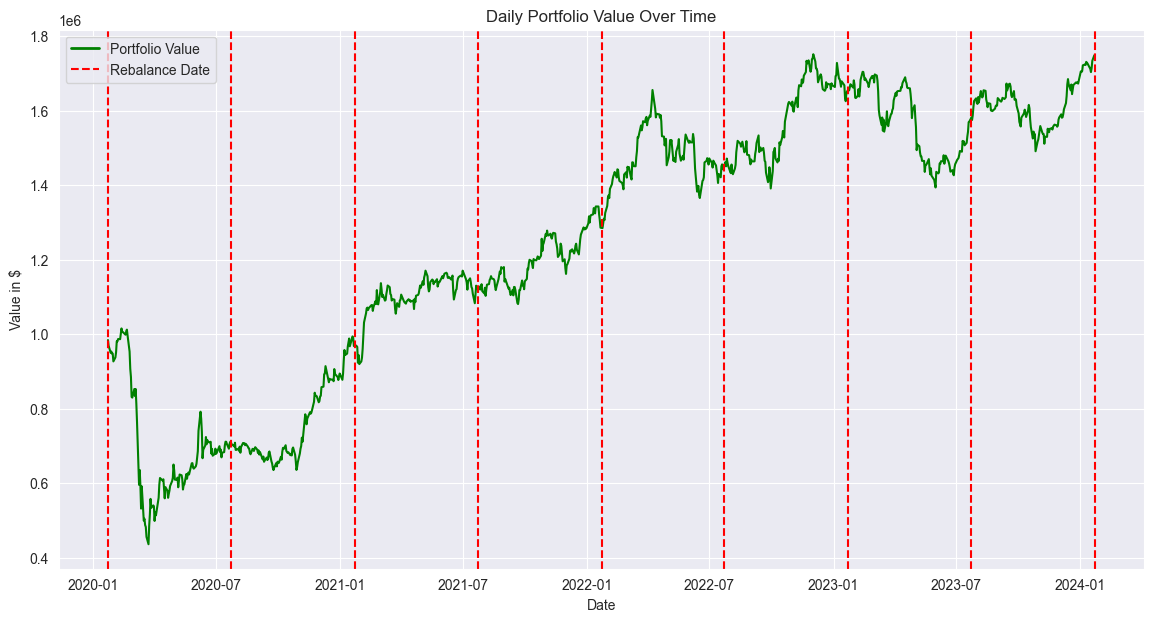

In [17]:
plot_portfolio_value(resultados_backtesting, tickers)

[*********************100%%**********************]  4 of 4 completed


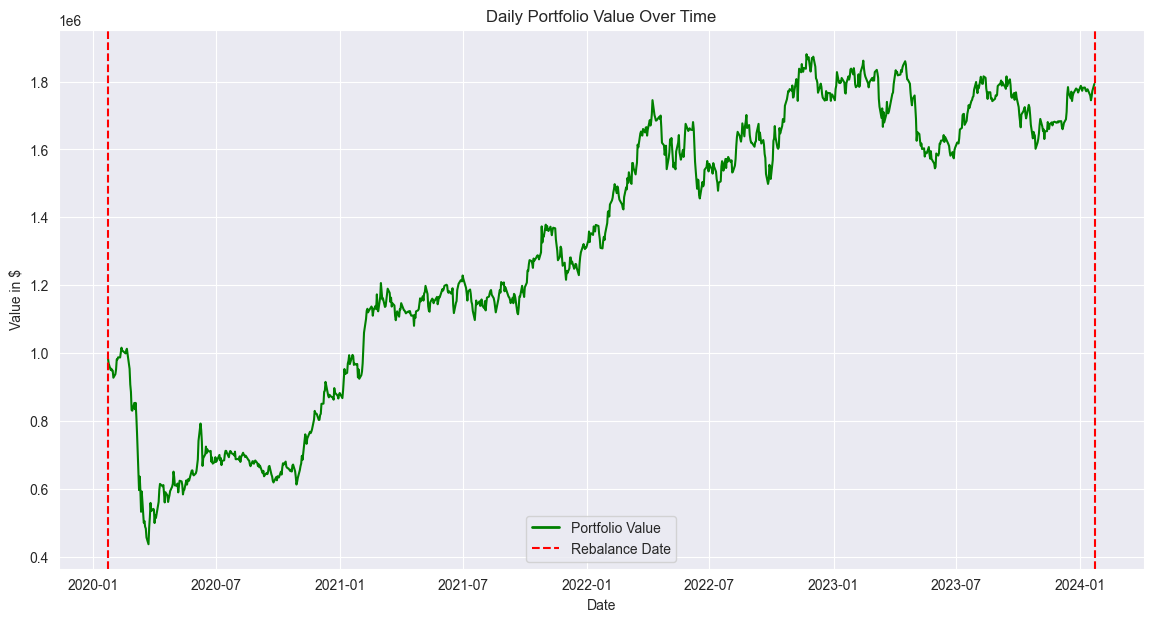

In [18]:
plot_portfolio_value(resultados_sin_backtesting, tickers)

## NEED VALIDATE MARTINGALE

## NEED VALIDATE ROY SAFETY FIRST RATIO

## SORTINO RATIO

In [19]:
strategies = ["Sortino Ratio"]

for strategy in strategies:
    QAA_instance.set_optimization_strategy(strategy)
    for model in optimization_models:
        QAA_instance.set_optimization_model(model)
        QAA_instance.optimize()
        if QAA_instance.optimal_weights is not None:
            print(f"\nOptimal weights in our class ({strategy} - {model}):", [format(weight, '.4f') for weight in QAA_instance.optimal_weights])
        else:
            print(f"\nOptimization for {strategy} with {model} did not converge or is not implemented.")


Optimal weights in our class (Sortino Ratio - SLSQP): ['0.3591', '0.1000', '0.1000', '0.4409']

Optimal weights in our class (Sortino Ratio - Monte Carlo): ['0.2979', '0.1009', '0.1001', '0.5011']

Optimal weights in our class (Sortino Ratio - COBYLA): ['0.3592', '0.1000', '0.1000', '0.4408']


## FAMMA - FRENCH

In [20]:

# Define a list of strategies to optimize
strategies = ["Fama French"]

for strategy in strategies:
    QAA_instance.set_optimization_strategy(strategy)
    for model in optimization_models:
        QAA_instance.set_optimization_model(model)
        QAA_instance.optimize()
        if QAA_instance.optimal_weights is not None:
            print(f"\nOptimal weights in our class ({strategy} - {model}):", [format(weight, '.4f') for weight in QAA_instance.optimal_weights])
        else:
            print(f"\nOptimization for {strategy} with {model} did not converge or is not implemented.")


Optimal weights in our class (Fama French - SLSQP): ['0.5469', '0.1000', '0.1000', '0.2531']

Optimal weights in our class (Fama French - Monte Carlo): ['0.4879', '0.1086', '0.1049', '0.2987']

Optimal weights in our class (Fama French - COBYLA): ['0.5470', '0.1000', '0.1000', '0.2530']


In [21]:
import pandas_datareader.data as web
tickers = ["ABBV", "MET", "OXY", "PERI"]
start_date = "2020-01-02"
end_date = "2024-01-24"


data = yf.download(tickers=tickers, start=start_date, end=end_date)["Adj Close"]
returns = data.pct_change().dropna()


ff_data = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start=start_date, end=end_date)[0]
ff_returns = ff_data[['Mkt-RF', 'SMB', 'HML']].loc[returns.index]

def fama_french(returns, ff_returns, ff_data, weights):
    """Optimizes the objective function using Fama-French factors."""
    all_returns = pd.concat([returns, ff_returns], axis=1)
    risk_free_rate = ff_data['RF'].mean()
    ff_weights = np.append(weights, np.zeros(3))  
    portfolio_returns = np.dot(all_returns, ff_weights)
    ff_covariance = np.cov(all_returns.T)
    portfolio_volatility = np.sqrt(np.dot(ff_weights.T, np.dot(ff_covariance, ff_weights)))
    ff_ratio = (portfolio_returns.mean() * 252 - risk_free_rate) / portfolio_volatility
    return -ff_ratio


objective_function = lambda weights: fama_french(returns, ff_returns, ff_data, weights)


initial_weights = np.ones(4) / 4


result = minimize(objective_function, initial_weights, method='SLSQP', bounds=[(0.1, 0.9)] * 4, constraints=({'type': 'eq', 'fun': lambda w: np.sum(w) - 1}))


optimal_weights = result.x


optimal_weights /= np.sum(optimal_weights)

print("Pesos óptimos:", optimal_weights)

[*********************100%%**********************]  4 of 4 completed


Pesos óptimos: [0.55094833 0.1        0.1        0.24905167]


## Sharpe Ratio

In [22]:

# Define a list of strategies to optimize
strategies = ["Sharpe Ratio"]

for strategy in strategies:
    QAA_instance.set_optimization_strategy(strategy)
    for model in optimization_models:
        QAA_instance.set_optimization_model(model)
        QAA_instance.optimize()
        if QAA_instance.optimal_weights is not None:
            print(f"\nOptimal weights in our class ({strategy} - {model}):", [format(weight, '.4f') for weight in QAA_instance.optimal_weights])
        else:
            print(f"\nOptimization for {strategy} with {model} did not converge or is not implemented.")

C:\Users\J3SVS\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\optimize\_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)



Optimal weights in our class (Sharpe Ratio - SLSQP): ['0.4993', '0.1000', '0.1000', '0.3007']

Optimal weights in our class (Sharpe Ratio - Monte Carlo): ['0.4998', '0.1006', '0.1029', '0.2967']

Optimal weights in our class (Sharpe Ratio - COBYLA): ['0.4999', '0.1000', '0.1000', '0.3001']


In [23]:
start_date = "2020-01-02"
end_date = "2024-01-24"
data = yf.download(tickers=tickers, start=start_date, end=end_date)["Adj Close"]
returns = data.pct_change().dropna()
rf = 0.02 

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  
bounds = tuple((0.1, 1) for _ in range(len(tickers)))  
sharpe_ratio = lambda w, returns: -( (np.sum(returns.mean() * w) - rf/100) * 252 / np.sqrt(np.dot(w.T, np.dot(returns.cov() * 252, w))))
initial_guess = np.array([1.0 / len(tickers) for _ in range(len(tickers))])

opt_results = minimize(sharpe_ratio, initial_guess, args=(returns,), method='SLSQP', bounds=bounds, constraints=constraints)

print("Pesos óptimos:", opt_results.x)

[*********************100%%**********************]  4 of 4 completed


Pesos óptimos: [0.50479511 0.1        0.1        0.29520489]


## HierarchicalRiskParity (HRP)

In [24]:
# Define a list of strategies to optimize
strategies = ["HRP"]

for strategy in strategies:
    QAA_instance.set_optimization_strategy(strategy)
    for model in optimization_models:
        QAA_instance.set_optimization_model(model)
        QAA_instance.optimize()
        if QAA_instance.optimal_weights is not None:
            print(f"\nOptimal weights in our class ({strategy} - {model}):", [format(weight, '.4f') for weight in QAA_instance.optimal_weights])
        else:
            print(f"\nOptimization for {strategy} with {model} did not converge or is not implemented.")


Optimal weights in our class (HRP - SLSQP): ['0.6313', '0.2111', '0.0629', '0.0947']

Optimal weights in our class (HRP - Monte Carlo): ['0.6313', '0.2111', '0.0629', '0.0947']

Optimal weights in our class (HRP - COBYLA): ['0.6313', '0.2111', '0.0629', '0.0947']


In [25]:
tickers = ["ABBV", "MET", "OXY", "PERI"]
start_date = "2020-01-02"
end_date = "2024-01-24"
data = yf.download(tickers=tickers, start=start_date, end=end_date)["Adj Close"]
returns = data.pct_change().dropna()
hrp_pypfopt = HRPOpt(returns)
weights_hrp_pypfopt = hrp_pypfopt.optimize()
weights_hrp_pypfopt

[*********************100%%**********************]  4 of 4 completed


OrderedDict([('ABBV', 0.6311740525351746),
             ('MET', 0.21115852403894206),
             ('OXY', 0.06293045725993998),
             ('PERI', 0.09473696616594335)])

### CVaR

In [26]:
# Define a list of strategies to optimize
strategies = ["CVaR"]

for strategy in strategies:
    QAA_instance.set_optimization_strategy(strategy)
    for model in optimization_models:
        QAA_instance.set_optimization_model(model)
        QAA_instance.optimize()
        if QAA_instance.optimal_weights is not None:
            print(f"\nOptimal weights in our class ({strategy} - {model}):", [format(weight, '.4f') for weight in QAA_instance.optimal_weights])
        else:
            print(f"\nOptimization for {strategy} with {model} did not converge or is not implemented.")


Optimal weights in our class (CVaR - SLSQP): ['0.7000', '0.1000', '0.1000', '0.1000']

Optimal weights in our class (CVaR - Monte Carlo): ['0.6584', '0.1336', '0.1048', '0.1032']

Optimal weights in our class (CVaR - COBYLA): ['0.6970', '0.1010', '0.1010', '0.1010']


# Black Litterman y Total Return

In [27]:
strategies = ["Black Litterman", "Total Return"]

for strategy in strategies:
    QAA_instance.set_optimization_strategy(strategy)
    for model in optimization_models:
        QAA_instance.set_optimization_model(model)
        QAA_instance.optimize()
        if QAA_instance.optimal_weights is not None:
            print(f"\nOptimal weights in our class ({strategy} - {model}):", [format(weight, '.4f') for weight in QAA_instance.optimal_weights])
        else:
            print(f"\nOptimization for {strategy} with {model} did not converge or is not implemented.")


Optimal weights in our class (Black Litterman - SLSQP): ['0.1000', '0.1000', '0.1000', '0.7000']

Optimal weights in our class (Black Litterman - Monte Carlo): ['0.1156', '0.1059', '0.1017', '0.6768']

Optimal weights in our class (Black Litterman - COBYLA): ['0.1000', '0.1000', '0.1000', '0.7000']

Optimal weights in our class (Total Return - SLSQP): ['0.7000', '0.1000', '0.1000', '0.1000']

Optimal weights in our class (Total Return - Monte Carlo): ['0.6697', '0.1158', '0.1071', '0.1075']

Optimal weights in our class (Total Return - COBYLA): ['0.6970', '0.1010', '0.1010', '0.1010']
